In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from umap import UMAP
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
import glob
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
import sklearn

## Data and Error Analysis

### TODOS:
#### Data analysis
* generate artificial data and visualize to see stronger trends
* test confusion matrix using artificial data
* test pca on real data?
* test t-SNE on artificial data

#### Temperature changing
* figure out what values to change to simulate changing temperature

### T-SNE
#### Notes
* There doesn't seem to be an extremely strong trend in the data? This sample may have been bad

In [27]:
def classification_on_real(dx, steps=50,fbm=False):
    N=np.shape(dx)[0]
    net_file = 'models/{}_new_model.h5'.format(steps)
    model = load_model(net_file)
    ##alpha_model = load_model('88_alpha_model.h5')
    
    if fbm:
        fbm_model = load_model('models/{}_fbm_alpha.h5'.format(steps))
    
    predictions = []
    values = []
    for j in range(N):
        dummy = np.zeros((1,steps-1,1))
        dummy[0,:,:] = np.reshape(dx[j,:], (steps-1, 1))
        y_pred = model.predict(dummy) # get the results for 1D 
        ##alpha_pred = alpha_model.predict(dummy)
        ymean = np.mean(y_pred,axis=0) # calculate mean prediction of N-dimensional trajectory 
        values.append(ymean.round(decimals=2))
        prediction = np.argmax(ymean,axis=0) # translate to classification
        predictions.append((j, prediction))
        ##print('y_pred {}'.format(y_pred))
        ##print('prediction {}'.format(prediction))
        ##print('alpha {}'.format(alpha_pred))
        if fbm and prediction == 0:
            fbm_alpha_pred = fbm_model.predict(dummy)
          ##print('fbm_coef {}'.format(fbm_alpha_pred))
    return values, predictions

def get_activations(dx, steps=50,fbm=False):
    N=np.shape(dx)[0]
    net_file = 'models/{}_new_model.h5'.format(steps)
    model = load_model(net_file)

    layer_name = 'concatenate_1'
    intermediate_layer_model = keras.Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    
    activations = []
    values = []
    for j in range(N):
        dummy = np.zeros((1,steps-1,1))
        dummy[0,:,:] = np.reshape(dx[j,:], (steps-1, 1))
        
        activations.append(intermediate_layer_model.predict(dummy)) # get the results for 1D
        
    return activations
def generate_dx(x):
    temp_x = x-np.mean(x)
    dx = np.diff(temp_x)
    dx = dx/np.std(dx)
    return dx

def tsne(dx, predictions, s=30, ax=None, markers = ["o",">","s"], color="tab:blue", fbm_coeffs=None, ctrw_alphas=None):
    embedded_dx = UMAP().fit_transform(dx)

    fbm_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 0])
    ctrw_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 2])
    brownian_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 1])

    fbm = None
    ctrw = None
    brownian = None
    plt_list = []
    plt_names = []
    if ax is None:
        ax = plt.axes()
        ax.figure.set_size_inches(12,8)
    if fbm_points.size != 0:
        if fbm_coeffs is not None:
            cmap = sns.cubehelix_palette(as_cmap=True)
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, 
                             c=fbm_coeffs*2,marker=markers[0], edgecolors='black',cmap=cmap)
        else:
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, c=color,marker=markers[0], edgecolors='black')
        plt_list.append(fbm)
        plt_names.append("fbm")
    if ctrw_points.size != 0:
        if ctrw_alphas is not None:
            cmap = sns.cubehelix_palette(as_cmap=True, rot=-0.4)
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, 
                              c=ctrw_alphas, marker=markers[1], edgecolors='black', cmap=cmap)
        else:
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, c=color, marker=markers[1], edgecolors='black')
        plt_list.append(ctrw)
        plt_names.append("ctrw")
    if brownian_points.size != 0:
        brownian = ax.scatter(brownian_points[:,0], brownian_points[:,1], s=s, c=color, marker=markers[2],edgecolors='black')
        plt_list.append(brownian)
        plt_names.append("brownian")

    plt.legend(plt_list, plt_names)
    return ctrw, ax

## Temperature Experiments
If Moire not specified in file it's 45!

In [28]:
all_temp_activations.shape

(20, 300, 192)

In [29]:
temperatures = np.linspace(1e-2, 5e-1, 20)

all_temp_activations = []
all_temp_predictions = []
all_temp_values = []
num_fbm = []
num_brownian = []
num_ctrw = []

for temp in temperatures:
    with open('sim_results/len50temp{}_1m.npy'.format(temp), 'rb') as f:
        x = np.load(f)
        y = np.load(f)
    temp_x = x-np.mean(x)
    temp_dx = np.diff(temp_x)
    temp_dx = temp_dx/np.std(temp_dx)

    temp_values, temp_predictions = classification_on_real(temp_dx)
    all_temp_activations.append(get_activations(temp_dx))
    
    num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
    num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
    num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))
    
    all_temp_predictions.append(temp_predictions)
    all_temp_values.append(temp_values)

all_temp_activations = np.array(all_temp_activations)

less monte carlo steps -> the std dev of the displacement between jumps should be lower relative to mean -> when normalized the model is more sensitive to smaller displacement -> so it's more likely to classify smaller displacement as brownian rather than some of them staying ctrw? not sure if this logic works exactly with taking more steps and evenly sampling and how that affects the distribution of displacements, but the model definitely classifies ctrw less

Text(0.5, 1.0, 'Temperature vs Proportion of Class (simulated data 100k monte carlo 10 moire)')

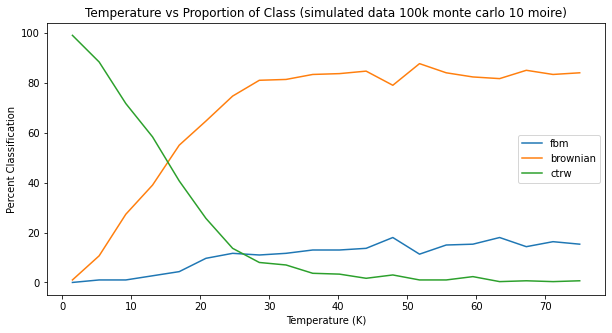

In [30]:
x = np.linspace(1e-2, 5e-1, 20) * 150
plt.plot(x, np.array(num_fbm) / 3, c="tab:blue",label="fbm")
plt.plot(x, np.array(num_brownian) / 3, c="tab:orange", label="brownian")
plt.plot(x, np.array(num_ctrw) / 3, c="tab:green",label="ctrw")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Percent Classification")
plt.title("Temperature vs Proportion of Class (simulated data 100k monte carlo 10 moire)")

### TSNE Temperature Activations


In [31]:
all_temp_activations = all_temp_activations.reshape((all_temp_activations.shape[0], 
                                                     all_temp_activations.shape[1],
                                                     all_temp_activations.shape[3]))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Text(0.5, 1.0, 'TSNE temperature sim 1k monte carlo')

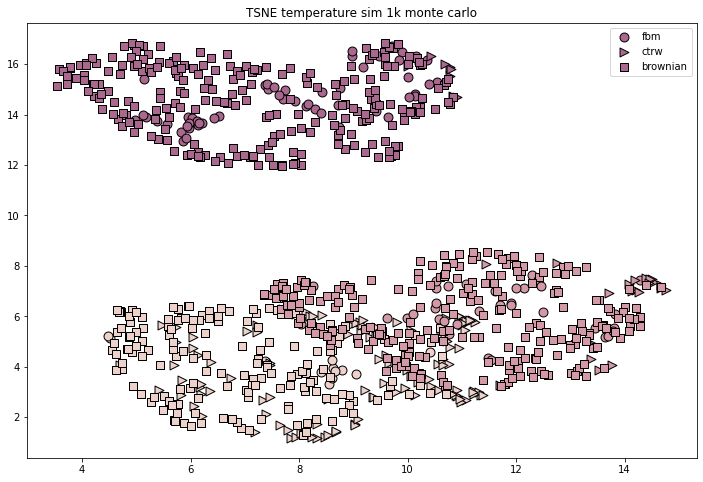

In [32]:
marker_size = 80
colors = sns.cubehelix_palette(9)
ctrw1, ax = tsne(all_temp_activations[4], all_temp_predictions[4], s = marker_size, color=colors[0])
ctrw2, ax = tsne(all_temp_activations[8], all_temp_predictions[8], s = marker_size, ax=ax, color=colors[2])
ctrw3, ax = tsne(all_temp_activations[12], all_temp_predictions[12], s = marker_size, ax=ax, color=colors[4])
# ctrw4, ax = tsne(all_temp_activations[16], all_temp_predictions[16], s = marker_size, ax=ax, color=colors[6])
# ctrw4, ax = tsne(all_temp_activations[19], all_temp_predictions[19],s = marker_size,  ax=ax, color=colors[8])

# marker_legend = plt.legend([ctrw1, ctrw2],labels =["4","8"])
# ax = plt.gca().add_artist(marker_legend)
plt.title("TSNE temperature sim 1k monte carlo")

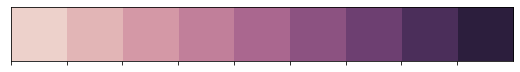

In [33]:
sns.palplot(colors)

### TSNE Vida Sim

In [34]:
with open('sim_track50.npy', 'rb') as f:
    vida_tracks = np.load(f)
    vida_labels = np.load(f)
    vida_labels = vida_labels.argmax(axis=1)
    vida_labels = [(i,x) for i, x in enumerate(vida_labels)]
with open('sim_track50_coeffs.npy', 'rb') as f:
    ctrw_alphas = np.load(f)
    fbm_coeffs = np.load(f)

In [35]:
vida_values, vida_preds = classification_on_real(vida_tracks)

In [36]:
vida_activations = np.array(get_activations(vida_tracks))

In [37]:
vida_activations = vida_activations.reshape((vida_activations.shape[0], 
                                                     vida_activations.shape[2]))

In [38]:
ctrw_track_inds = [i for i, x in enumerate(vida_labels) if x[1] == 2]
fbm_track_inds = [i for i, x in enumerate(vida_labels) if x[1] == 0]

Text(0.5, 1.0, "Actual Class and Actual Alpha value t-SNE for Vida's Sim")

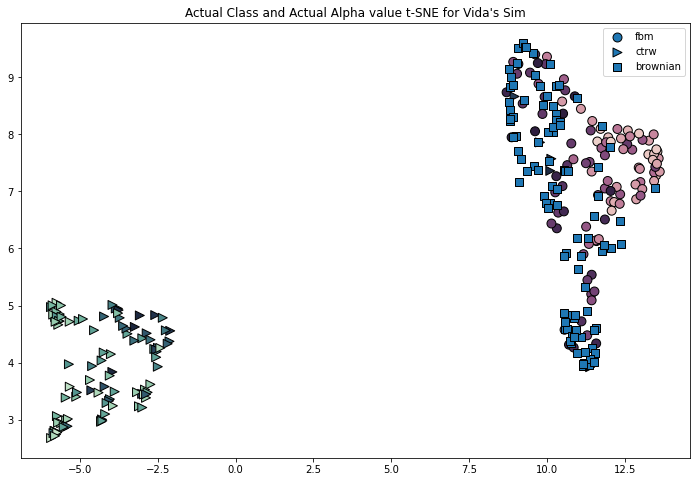

In [39]:
tsne(vida_activations, vida_labels, s = marker_size, fbm_coeffs=fbm_coeffs, ctrw_alphas=ctrw_alphas)
plt.title("Actual Class and Actual Alpha value t-SNE for Vida's Sim")

## Filter Visualization

In [40]:
net_file = 'models/50_new_model.h5'
model = load_model(net_file)

In [41]:
model.layers[1]


In [42]:
conv_layers = [x for x in model.layers if isinstance(x, keras.layers.Conv1D)]



In [43]:
[print(x.get_weights()[0].shape) for x in conv_layers]

(2, 1, 32)
(2, 1, 32)
(3, 1, 32)
(3, 1, 32)
(4, 1, 32)
(2, 32, 32)
(2, 32, 32)
(3, 32, 32)
(3, 32, 32)
(4, 32, 32)
(2, 32, 32)
(2, 32, 32)
(3, 32, 32)
(3, 32, 32)
(4, 32, 32)
(3, 1, 32)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [44]:
conv_layers[-5].output_shape

(None, 49, 32)

In [45]:
all_temp_activations.shape

(20, 300, 192)

In [46]:
all_temp_values

[[array([0.05, 0.09, 0.86], dtype=float32),
  array([0.07, 0.17, 0.77], dtype=float32),
  array([0.01, 0.03, 0.96], dtype=float32),
  array([0.02, 0.07, 0.92], dtype=float32),
  array([0.02, 0.04, 0.94], dtype=float32),
  array([0.  , 0.01, 0.98], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0.  , 0.  , 0.99], dtype=float32),
  array([0.  , 0.01, 0.98], dtype=float32),
  array([0.01, 0.04, 0.96], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0.05, 0.11, 0.84], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0.01, 0.13, 0.86], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0.02, 0.06, 0.92], dtype=float32),
  array([0.01, 0.02, 0.97], dtype=float32),
  array([0.05, 0.11, 0.84], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0.02, 0.04, 0.95], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0.0